# **<span style="color:CadetBlue;"> Proyecto ML: "Employee Absenteeism at Work" </span>**

![Absentismo](src/img/img_inicio.png)

El absentismo laboral es un problema común en las organizaciones y tiene un impacto directo en la productividad, la planificación operativa y el clima laboral. Comprender y anticipar los patrones de ausencia puede ayudar a la empresa a diseñar estrategias más eficaces de gestión del talento, prevención de ausencias y promoción del bienestar laboral.

El objetivo de este proyecto es predecir si un empleado se ausentará del trabajo (o clasificar el tipo o nivel de absentismo) en función de sus características personales y laborales. A través de un enfoque de aprendizaje automático supervisado, se busca detectar patrones de comportamiento asociados al absentismo, con el fin de anticipar posibles casos y mejorar la toma de decisiones.

Entre las preguntas que se pretende responder se encuentran:

* ¿Qué variables personales o laborales están más relacionadas con el absentismo?

* ¿Es posible predecir si un empleado faltará al trabajo en función de su perfil?

Este análisis se basa en el dataset [“Absenteeism at Work”](https://archive.ics.uci.edu/dataset/445/absenteeism+at+work), que contiene registros de ausencias de empleados de una empresa en Brasil, junto con información médica, personal y laboral relevante.

In [1]:
from src.utils import bootcampviztools as bt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [3]:
from src.utils.funciones import recode_features, func_exclude_columns, evaluate_model, map_categoricals

## 1. Entender el problema

El dataset **“Absenteeism at Work”** contiene información sobre empleados, factores sociales y laborales, y el número de horas que estuvieron ausentes del trabajo.

Se trata de un **problema de aprendizaje supervisado**, ya que cuenta con una variable objetivo clara: **`Absenteeism time in hours`**.

En un primer enfoque como **problema de regresión**, los resultados no fueron satisfactorios debido a:

- **Baja correlación entre las variables independientes y el target.**
- **Tamaño de muestra limitado.**

Por ello, tras un análisis exploratorio y transformaciones iniciales, se decidió reformularlo como **problema de clasificación**, con el objetivo de facilitar interpretaciones útiles para la empresa.

El **percentil 50 del target son 3 horas**, por lo que se definieron las clases de la siguiente forma:
- **No ausente**: menos de 3 horas de ausencia.
- **Ausente**: 3 o más horas de ausencia.

Esta definición permite obtener:

* Un target más equilibrado.  
* Una interpretación más alineada con la realidad operativa de la empresa, distinguiendo entre ausencias que la empresa puede asumir y aquellas que representan una falta significativa.

---

### Métricas utilizadas para evaluar el modelo de clasificación:
- **Accuracy**
- **Precision**
- **Recall**

Estas métricas permiten evaluar la capacidad del modelo para identificar correctamente a los empleados ausentes y minimizar tanto falsos positivos como falsos negativos en un contexto de absentismo laboral.


## 2. Carga de datos

In [4]:
df = pd.read_csv("./src/data_sample/Absenteeism_at_work.csv", sep=";")

In [5]:
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [ ]:
df.info() #dataset sin nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [7]:
df = recode_features(df)

*Con esta función convertimos el problema en clasificación, modificando:*

* Target: `Absenteeism time in hours` a `absent` --> ha faltado (>3h)=1, no ha faltado(<3h)=0
* Education: agrupando la división de 1 = instituto, 2 = graduado, 3 = postgrado, 4 = doctorado a 1 = instituto, 2 = educación superior
* Pets: `Pet`a `Has_pet` --> no tiene mascotas = 0, tiene mascotas = 1
* Children: `Son`a `Has_son` --> no tiene hijos = 0, tiene hijos = 1

In [8]:
df_transformado = func_exclude_columns(df)

target= "absent"

*Con esta función eliminamos del dataset ciertas columnas que no aportan como:*
* `ID`
* `Height` y `Weight`: se encuentran en `Body mass index`
* `Disciplinary failure`: varaible totalmente desbalanceada con 700 instancias = 0 y 40 = 1
* `Pet`, `Son` y `Absenteeism time in hours`: ya modificadas

In [ ]:
df_transformado.info() #nuevas columnas y la exclusión de otros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reason for absence               740 non-null    int64  
 1   Month of absence                 740 non-null    int64  
 2   Day of the week                  740 non-null    int64  
 3   Seasons                          740 non-null    int64  
 4   Transportation expense           740 non-null    int64  
 5   Distance from Residence to Work  740 non-null    int64  
 6   Service time                     740 non-null    int64  
 7   Age                              740 non-null    int64  
 8   Work load Average/day            740 non-null    float64
 9   Hit target                       740 non-null    int64  
 10  Education                        740 non-null    int64  
 11  Social drinker                   740 non-null    int64  
 12  Social smoker         

## 3. Train y test

In [10]:
train_set, test_set = train_test_split(df_transformado, test_size=0.2, random_state=42)

## 4. MiniEDA

*Target*

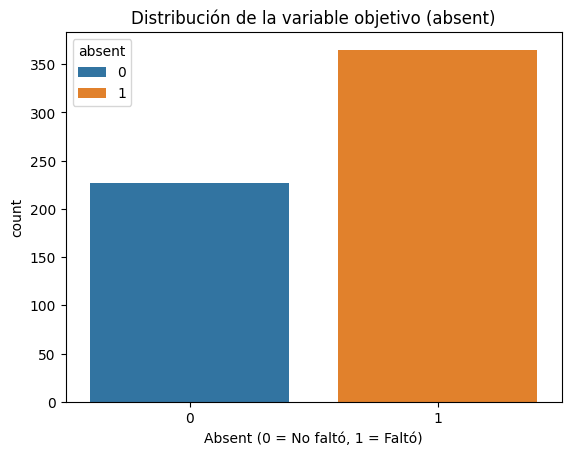

In [11]:
sns.countplot(x="absent", data=train_set, hue="absent")
plt.title("Distribución de la variable objetivo (absent)")
plt.xlabel("Absent (0 = No faltó, 1 = Faltó)")
plt.show()

Feature | Tipo | Descripción |
| ------ | ---- | -------- |
Reason for absence|	Categórica nominal|	Código de razón médica/social de la ausencia (0–28).
Month of absence|	Categórica nominal	|Mes en que ocurrió la ausencia (1 = enero, ..., 12 = diciembre).
Day of the week|	Categórica nominal	|Día de la semana (2 = lunes, 3 = martes, 4 = miércoles, 5 = jueves, 6 = viernes).
Seasons	| Categórica nominal |	Estación del año (1 = verano, ..., 4 = primavera).
Transportation expense |	Numérica continua	|Gasto mensual en transporte (en euros).
Distance from Residence to Work |	Numérica continua	|Distancia desde la residencia al trabajo (en km).
Service time|	Numérica discreta|	Años de antigüedad en la empresa.
Age	|Numérica continua|	Edad del empleado (en años).
Work load Average/day |	Numérica continua	|Carga de trabajo promedio por día (en minutos). 
Hit target |	Numérica discreta |	Porcentaje de cumplimiento de objetivos.
Education |	Categórica ordinal |	Nivel educativo (1 = instituto, 2 = educación superior).
Son |	Numérica discreta|	Número de hijos. (*tratar como categórica)
Social drinker|	Categórica binaria |	0 = no, 1 = sí (consume alcohol socialmente).
Social smoker |	Categórica binaria |	0 = no, 1 = sí (fuma en contexto social).
Pet	| Numérica discreta |	Número de mascotas. (*tratar como categórica)
Body mass index (BMI)|	Numérica continua|	Índice de masa corporal. Calculado a partir de peso y altura.

(7, 2)


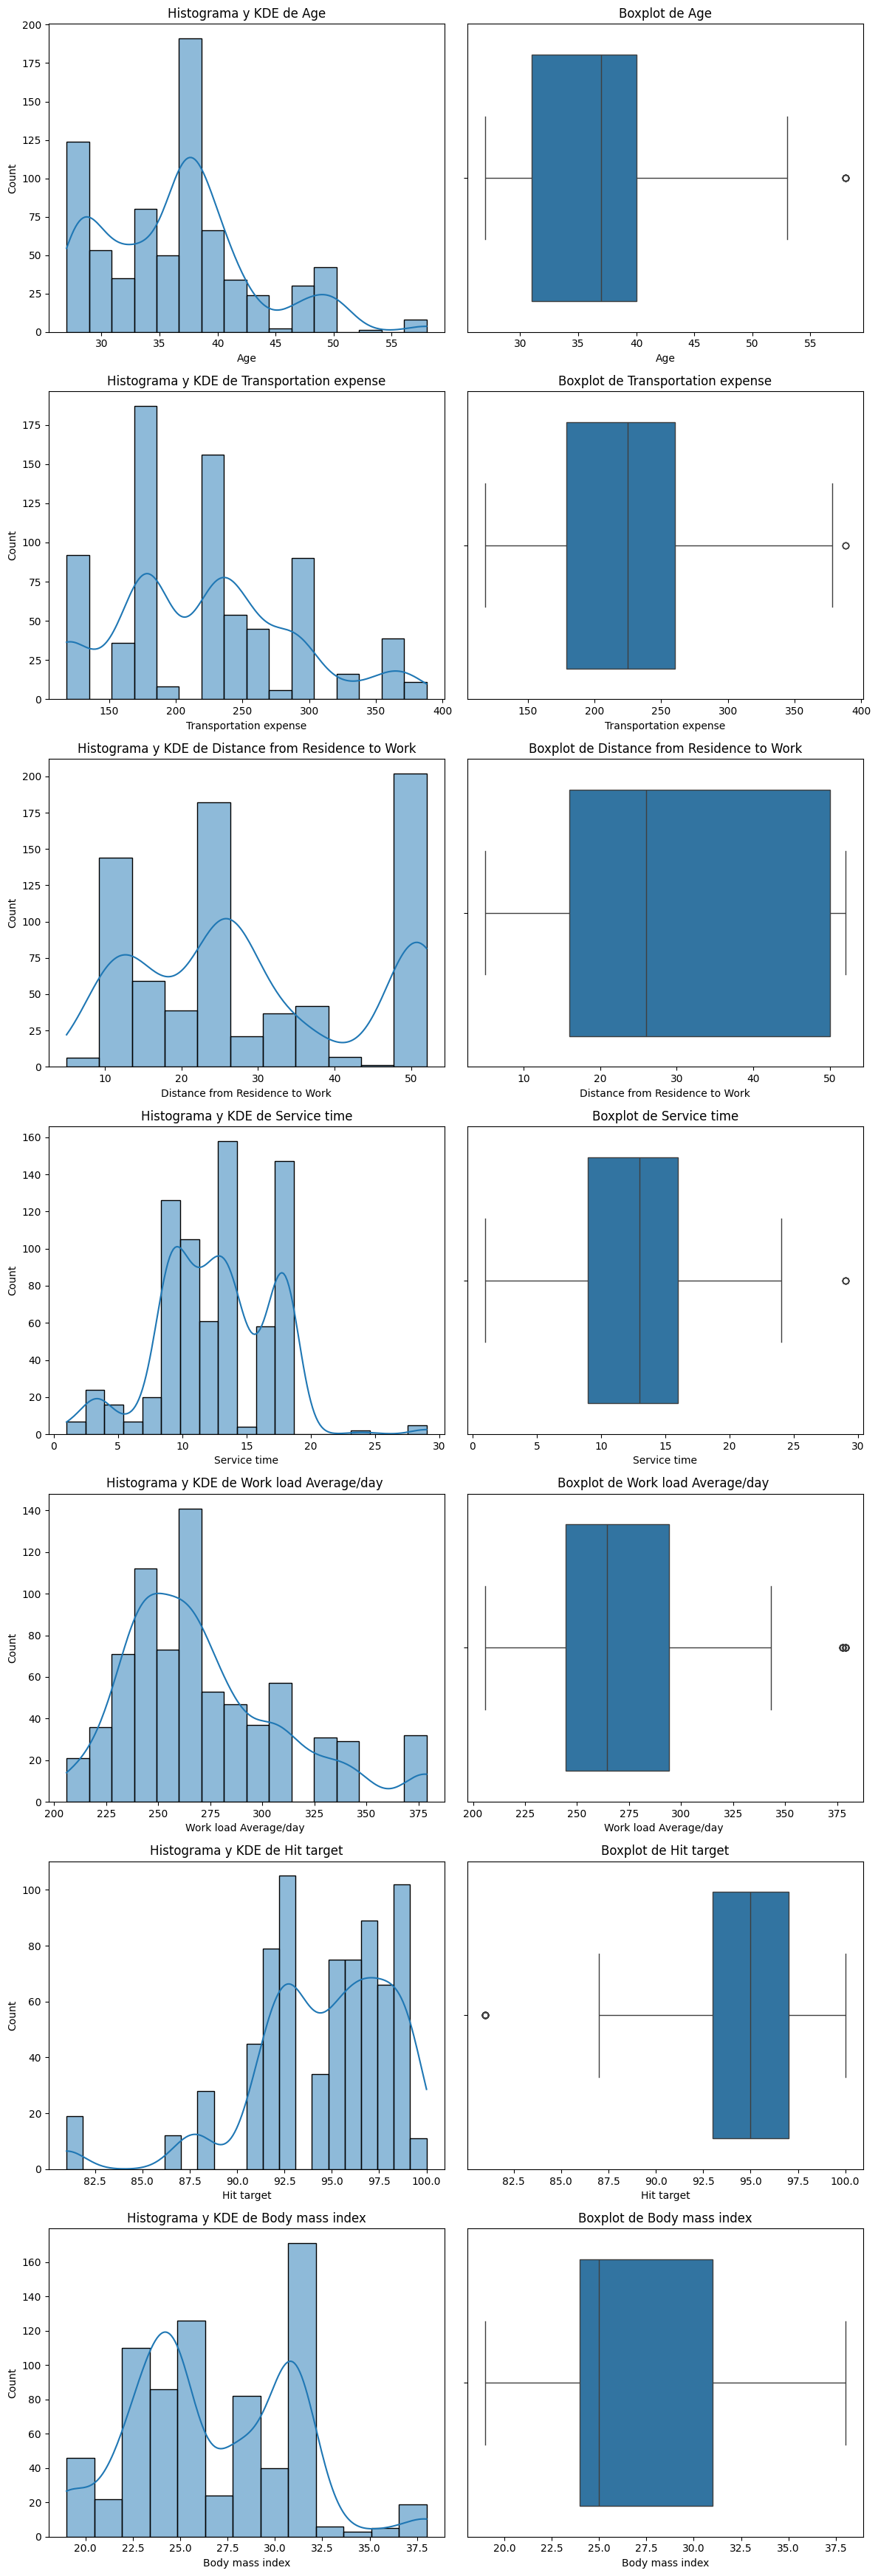

In [12]:
features_num=["Age", "Transportation expense", "Distance from Residence to Work", 
                "Service time", "Work load Average/day ", "Hit target", "Body mass index"]

bt.plot_combined_graphs(df, [col for col in features_num])

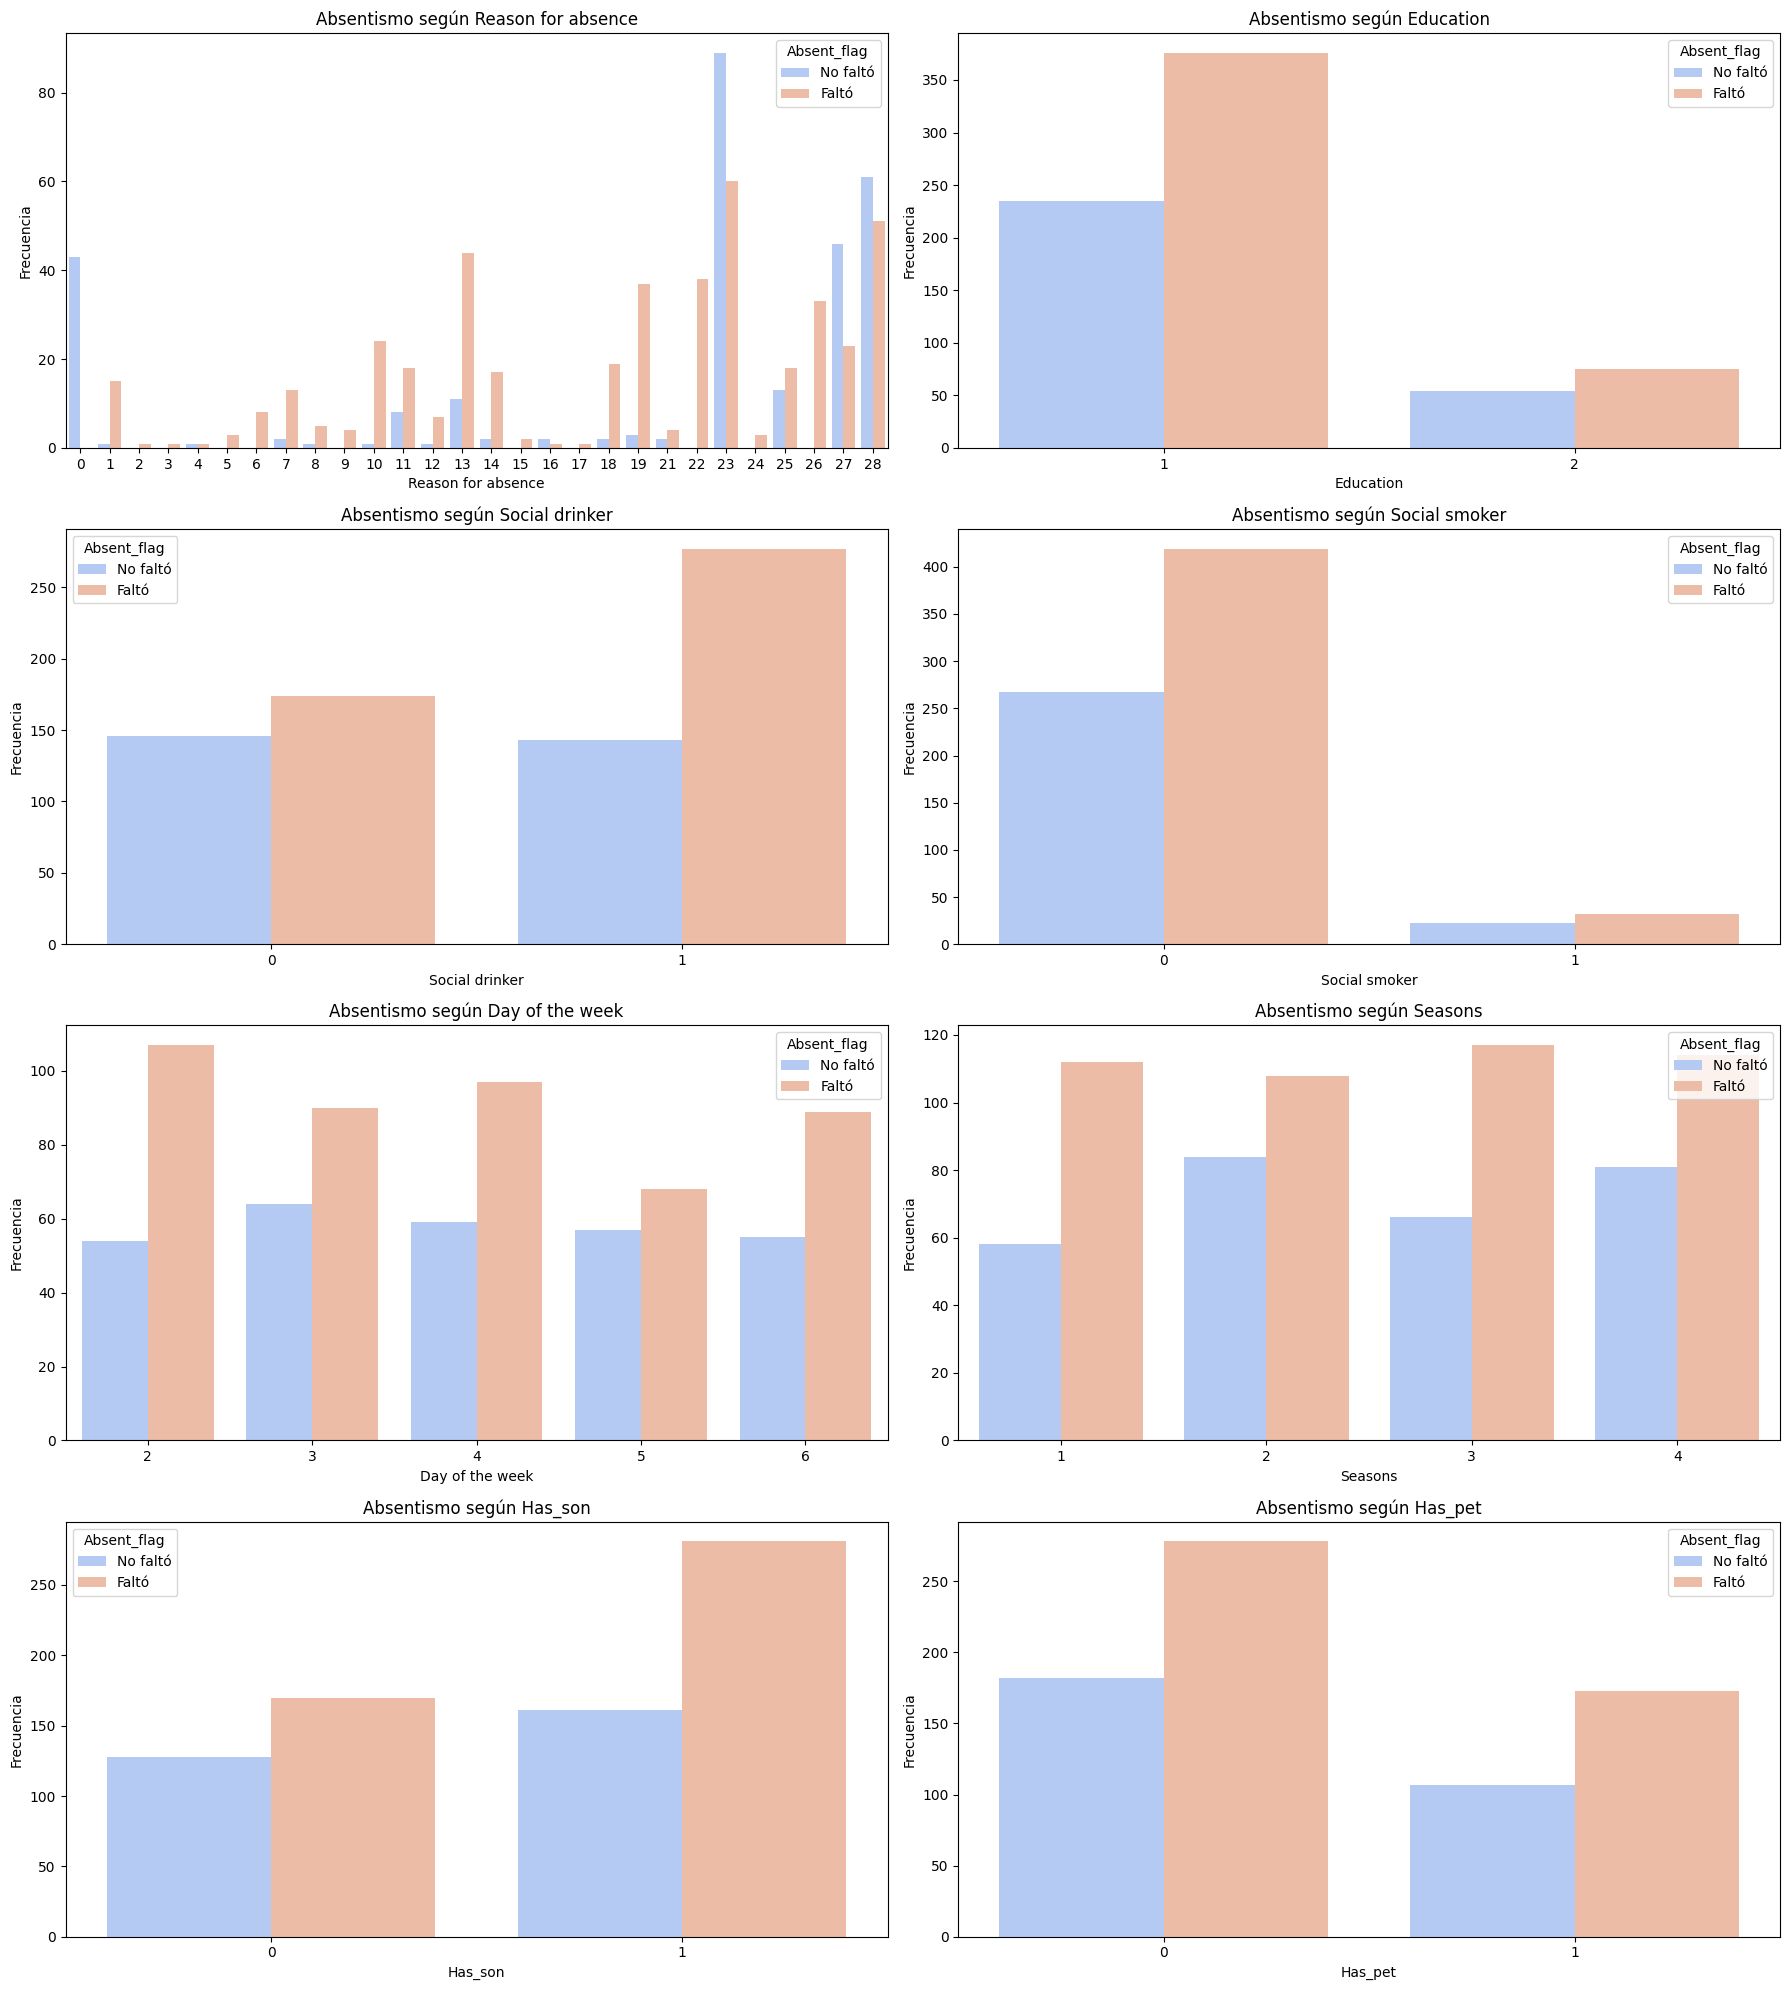

In [ ]:
features_cat = ["Reason for absence", "Education", "Social drinker", "Social smoker", "Day of the week", "Seasons", "Has_son", "Has_pet"]

plt.figure(figsize=(18, 20))
for i, var in enumerate(features_cat):
    plt.subplot(4, 2, i+1)
    sns.countplot(x=var, hue="absent", data=df, palette="coolwarm")
    plt.title(f"Absentismo según {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.legend(title="Absent", labels=["Sin ausencias", "Con ausencias"])

plt.tight_layout()
plt.show()

*Ser un fumador social no implica mayor horas de absentismo, como es el caso de ser un bebedor social, aunque las variaciones no son especialmente destacables*

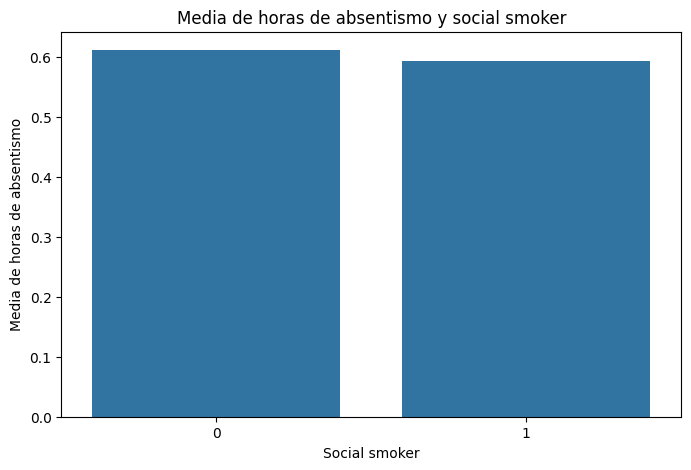

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(x='Social smoker', y=target, data=df, estimator='mean', errorbar=None)
plt.title('Media de horas de absentismo y social smoker')
plt.ylabel('Media de horas de absentismo')
plt.show()


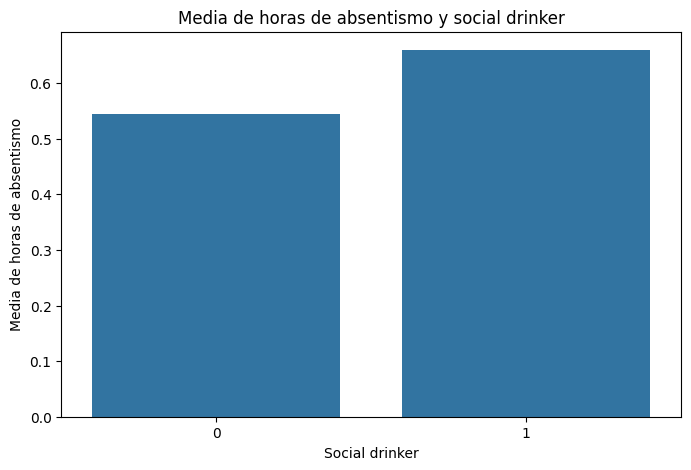

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(x='Social drinker', y=target, data=df, estimator='mean', errorbar=None)
plt.title('Media de horas de absentismo y social drinker')
plt.ylabel('Media de horas de absentismo')
plt.show()

*Tener o no mascotas no influye tanto en el aumento de horas de absentismo como tener o no hijos*

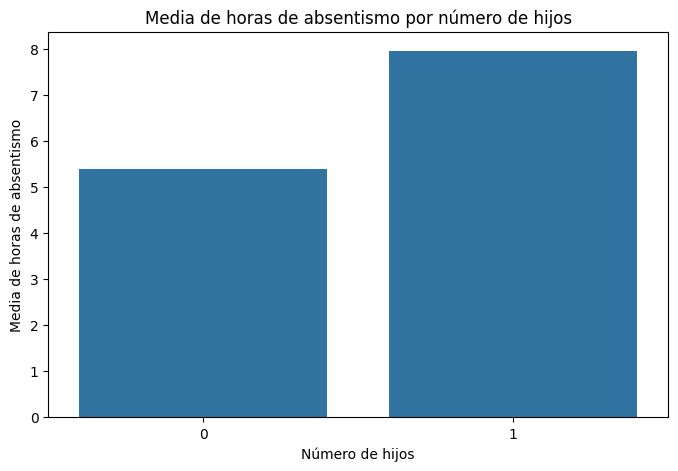

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x='Has_son', y='Absenteeism time in hours', data=df, estimator='mean', errorbar=None)
plt.title('Media de horas de absentismo por número de hijos')
plt.xlabel('Número de hijos')
plt.ylabel('Media de horas de absentismo')
plt.show()

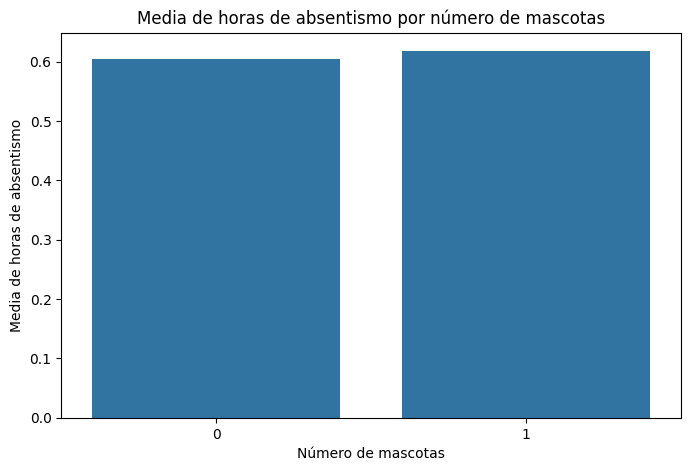

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x='Has_pet', y=target, data=df, estimator='mean', errorbar=None)
plt.title('Media de horas de absentismo por número de mascotas')
plt.xlabel('Número de mascotas')
plt.ylabel('Media de horas de absentismo')
plt.show()


*Entre las variables eliminadas se encuentran `Height` y `Weight`:*

In [18]:
df['BMI_calculado'] = df['Weight'] / ((df['Height'] / 100) ** 2)

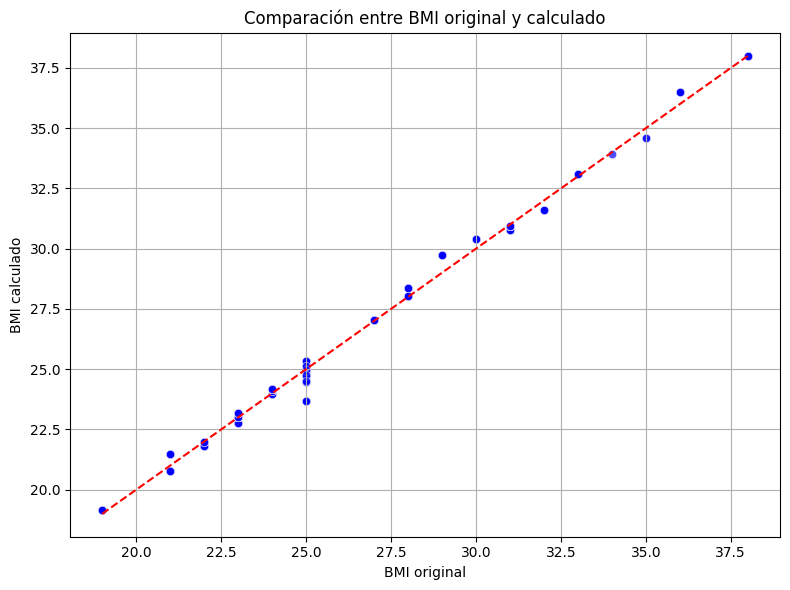

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Body mass index'], y=df['BMI_calculado'], alpha=0.7, color='blue')
plt.plot([df['Body mass index'].min(), df['Body mass index'].max()],
         [df['Body mass index'].min(), df['Body mass index'].max()],
         color='red', linestyle='--')
plt.xlabel('BMI original')
plt.ylabel('BMI calculado')
plt.title('Comparación entre BMI original y calculado')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#diferencia
diff = (df['Body mass index'] - df['BMI_calculado']).abs().mean()
print(f"Diferencia media entre BMI original y calculado: {diff:.4f}")

Diferencia media entre BMI original y calculado: 0.2154


## 5. Transformaciones

In [21]:
X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

*Para numéricas*

In [22]:
log_feats = ['Transportation expense', 'Work load Average/day ', 'Body mass index']

log_transformer = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', RobustScaler())
])

log_only =Pipeline([
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one'))])

# Para las demás
std_feats = ['Distance from Residence to Work', 'Service time', 'Age', 'Hit target']

std_transformer = StandardScaler()

*Para categóricas*

In [ ]:
cat_to_encode=["Reason for absence", "Month of absence", "Day of the week", "Seasons"]
categorical_pipeline = Pipeline([
    ('map_cats', FunctionTransformer(map_categoricals, feature_names_out='one-to-one')), #nuevos nombres columnas
    ('onehot', ColumnTransformer([
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_to_encode)
    ], remainder='passthrough'))
])


In [24]:
# Pipeline de preprocesamiento completo
preprocessing = ColumnTransformer(
    transformers=[
        ("Transform_Log", log_transformer, log_feats),
        ("Transform_Std", std_transformer, std_feats),
        ("Process_Categorical", categorical_pipeline, cat_to_encode),
    ],
    remainder="passthrough"
)

In [25]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Transform_Log',
                                 Pipeline(steps=[('log1p',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaler', RobustScaler())]),
                                 ['Transportation expense',
                                  'Work load Average/day ',
                                  'Body mass index']),
                                ('Transform_Std', StandardScaler(),
                                 ['Distance from Residence to Work',
                                  'Service time', 'Age', '...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function map_categoricals at 0x000001A840B8BBA0>)),
                                                 ('onehot',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehot',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Reason '
                                                                                    'for '
                                                                                    'absence',
                                                                                    'Month '
                                                                                    'of '
                                                                                    'absence',
                                                                                    'Day '
                                                                                    'of '
                                                                                    'the '
                                                                                    'week',
                                                                                    'Seasons'])]))]),
                                 ['Reason for absence', 'Month of absence',
                                  'Day of the week', 'Seasons'])])

In [26]:
pipe_preprocessed = preprocessing.fit_transform(X_train)
pipe_preprocessed

array([[ 1.02696664,  0.2210242 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67107207,  0.08638246,  0.61140642, ...,  0.        ,
         1.        ,  1.        ],
       [ 1.32673939,  0.4046466 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.61248781,  0.57899759,  0.72176679, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.38394297, -0.13633353, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.        , -0.0603505 , -0.13633353, ...,  0.        ,
         1.        ,  1.        ]], shape=(592, 60))

In [27]:
preprocessing.get_feature_names_out()

array(['Transform_Log__Transportation expense',
       'Transform_Log__Work load Average/day ',
       'Transform_Log__Body mass index',
       'Transform_Std__Distance from Residence to Work',
       'Transform_Std__Service time', 'Transform_Std__Age',
       'Transform_Std__Hit target',
       'Process_Categorical__onehot__Reason for absence_Blood',
       'Process_Categorical__onehot__Reason for absence_Blood-donation',
       'Process_Categorical__onehot__Reason for absence_Circulatory',
       'Process_Categorical__onehot__Reason for absence_Consultation',
       'Process_Categorical__onehot__Reason for absence_Dentist',
       'Process_Categorical__onehot__Reason for absence_Digestive',
       'Process_Categorical__onehot__Reason for absence_Ear',
       'Process_Categorical__onehot__Reason for absence_Endocrine',
       'Process_Categorical__onehot__Reason for absence_Eye',
       'Process_Categorical__onehot__Reason for absence_Follow-up',
       'Process_Categorical__onehot__R

## 6. Modelos

In [28]:
modelos_escalados = {
    "Logistic": LogisticRegression(max_iter=2000, class_weight="balanced")
}

modelos_no_escalados = {
    "RandomF": RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced"),
    "XGB": XGBClassifier(max_depth=10, random_state=42, n_jobs=-1),
    "LGB": LGBMClassifier(max_depth=10, random_state=42, verbose=-100, class_weight="balanced", n_jobs=-1)
}

In [29]:
pipelines={}

for nombre, modelo in modelos_escalados.items():
    pipe = Pipeline([
        ("preprocessing", preprocessing),  #ColumnTransformer con escalado
        ("classifier", modelo)
    ])
    pipelines[f"{nombre}_scaled"] = pipe

# Para modelos que NO necesitan escalado
for nombre, modelo in modelos_no_escalados.items():
    pipe = Pipeline([
        ("log", log_only),
        ("categoricals", categorical_pipeline),  # mapea y one-hot, las numéricas no las escalamos
        ("classifier", modelo)
    ])
    pipelines[f"{nombre}_no_scaled"] = pipe

In [30]:
for nombre, pipeline in pipelines.items():
    print(f"Evaluando modelo: {nombre}")
    pipeline.fit(X_train, y_train)
    pred_test = pipeline.predict(X_test)
    evaluate_model(y_test, pred_test)
    print(classification_report(y_test, pred_test))
    print("-" * 60)

Evaluando modelo: Logistic_scaled


✔️ Sensibilidad (Recall): 0.71
✔️ Especificidad: 0.81
✔️ Precisión (Precision): 0.84
✔️ Exactitud (Accuracy): 0.75
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        62
           1       0.84      0.71      0.77        86

    accuracy                           0.75       148
   macro avg       0.75      0.76      0.75       148
weighted avg       0.76      0.75      0.75       148

------------------------------------------------------------
Evaluando modelo: RandomF_no_scaled
✔️ Sensibilidad (Recall): 0.86
✔️ Especificidad: 0.47
✔️ Precisión (Precision): 0.69
✔️ Exactitud (Accuracy): 0.70
              precision    recall  f1-score   support

           0       0.71      0.47      0.56        62
           1       0.69      0.86      0.77        86

    accuracy                           0.70       148
   macro avg       0.70      0.66      0.66       148
weighted avg       0.70      0.70      0.68       148

-------------------

c:\Users\emmag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*Logistic_scaled ofrece un excelente equilibrio entre recall, precisión y especificidad, es el más robusto para entornos donde tanto los falsos negativos como los positivos son importantes. Pero hacemos GridSearch a todos para buscar los mejores hiperparámetros*

In [ ]:
# Definimos sus hiperparametros
reg_log_param = {
    "penalty": ["l1","l2"], 
    "C": [0.1, 0.5, 1.0, 5.0], 
    "max_iter": [50,100,500],
    "solver": ["liblinear"],  # Suele ser el más rápido
    "class_weight": ["balanced", None]
    }

rand_forest_param = {
    'n_estimators': [100, 200, 400],
    "max_depth": [3,4,5,6,10,15,17],
    'min_samples_leaf': [1,10,20,100],
    'class_weight':['balanced', None],
    "max_features": ["sqrt", 3, 4]
}

xgb_param = {
    "n_estimators": [10, 100, 200, 400],
    "max_depth": [1,2,4,8],
    "learning_rate": [0.1,0.2,0.5,1.0],
    "scale_pos_weight": [len(y_train[y_train == 0])/len(y_train[y_train == 1]), 1]
}

lgb_param = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.1, 0.3, 0.6, 1], 
    'max_depth': [1, 6, 10, -1],  
    'min_child_samples': [1, 10, 20, 100], 
    'scale_pos_weight': [
        len(df[df[target]==0]) / len(df[df[target]==1]),
        1],
    'colsample_bytree': [0.5, 1]
}

In [33]:
cv = 5

gs_reg_log = GridSearchCV(LogisticRegression(),
                          reg_log_param,
                          cv=cv,
                          scoring="balanced_accuracy",
                          verbose=1,
                          n_jobs=-1
                          )


gs_rand_forest = GridSearchCV(RandomForestClassifier(),
                              rand_forest_param,
                              cv=cv,
                              scoring="balanced_accuracy",
                              verbose=1,
                              n_jobs=-1)

gs_xgb = GridSearchCV(XGBClassifier(),
                      xgb_param,
                      cv=cv,
                      scoring="balanced_accuracy",
                      verbose=1,
                      n_jobs=-1)

gs_lgb = GridSearchCV(LGBMClassifier(),
                      lgb_param,
                      cv=cv,
                      scoring="balanced_accuracy",
                      verbose=1,
                      n_jobs=-1)


pipe_grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb,
         "gs_lgb":gs_lgb}

In [34]:
for nombre, grid_search in pipe_grids.items():
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


In [35]:
best_grids = [(i, j.best_score_) for i, j in pipe_grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
3,gs_lgb,0.789393
2,gs_xgb,0.777105
1,gs_rand_forest,0.746530
0,gs_reg_log,0.584486


In [36]:
best_model = pipe_grids[best_grids.iloc[0,0]]
best_model

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1],
                         'learning_rate': [0.1, 0.3, 0.6, 1],
                         'max_depth': [1, 6, 10, -1],
                         'min_child_samples': [1, 10, 20, 100],
                         'n_estimators': [100, 200, 400],
                         'scale_pos_weight': [0.6407982261640798, 1]},
             scoring='balanced_accuracy', verbose=1)

*Es el que más tarda en ejecutarse, pero con al dipsoner de tiempo, es el que da mejor resultados*

In [ ]:
import joblib
joblib.dump(best_model, './src/models/modelo_pipeline.joblib')

['./src/models/modelo_pipeline.joblib']

# Comprobaciones

In [ ]:
dataset_new = pd.read_csv("./src/data_sample/absenteeism_test.csv") #cargamos nuevo dataset simulado

#aplicamos mismas transformaiones iniciales
df_new=recode_features(dataset_new)

df_new = func_exclude_columns(df_new)

target= "absent"


X_test_new = df_new.drop(columns=[target])
y_test_new = df_new[target]

In [ ]:
best_model.predict(X_test_new) #predicciones según el mejor modelo entrenado

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1])

In [ ]:
print(classification_report(y_test_new, best_model.predict(X_test_new))) #evaluación

              precision    recall  f1-score   support

           0       0.37      0.32      0.34        85
           1       0.54      0.60      0.57       115

    accuracy                           0.48       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.47      0.48      0.47       200



*El modelo LightGBM aplicado en esta evaluación presenta un rendimiento moderado en la detección de casos de absentismo laboral (clase 1), con un recall del 60%, lo que indica que identifica correctamente la mayoría de los empleados que faltan al trabajo.*

*Sin embargo, su capacidad para identificar correctamente a quienes no presentan absentismo (clase 0) es limitada, con un recall del 32% y una precisión del 37%, lo que sugiere que el modelo tiende a sobrepredecir la clase 1.*